Copyright © The University of Edinburgh, 2024.

Development has been supported by GSK.

## Hyperparameter scanning
Scanning was carried out by submitting the following command via slurm to an HPC cluster, reserving one node with an NVIDIA 3090Ti GPU, as the optuna scan is to use only one noder, we run with reseed = None, and turn off the median pruner which is an Optuna optimization which aborts trials which do not look to be performing better than the median for their given progression through training.

```console
leakproofcmap --random_state=7 tripletloss optuna_scan 24 --n_optuna_trials_per_job=1000 --db_filename_suffix=1node_HPC1 --reseed=None --use_median_pruner=False
```

The top 5 models are summarised below:


In [1]:
from pathlib import Path
working_dir="working_dir"

import optuna
from pathlib import Path
working_dir=Path("working_dir")

f=working_dir/"TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db"
all_summaries=optuna.get_all_study_summaries(f"sqlite:///{f}")
study_name=all_summaries[0].study_name
study = optuna.load_study(
    storage=f"sqlite:///{f}",
    study_name=study_name,
)
print(f"Study user attributes: {study.user_attrs}")
optuna_df = study.trials_dataframe()
print(f"{optuna_df.shape=}")
optuna_df = optuna_df.query("state=='COMPLETE'").rename(columns={"number": "trial", "value": "val_loss"}).set_index("trial").sort_values("user_attrs_val_accuracy", ascending=False)
optuna_df.to_csv(f.with_suffix(".csv"))
display(optuna_df.head(5))
display(f"{optuna_df.shape} entries after filtering for 'COMPLETE'")

Study user attributes: {'instantiate_model_from_trial_kwargs': {}, 'model_name': 'TripletLoss', 'random_state': 7}
optuna_df.shape=(533, 20)


,val_loss,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_embedding_size_po2,params_layer_0_size,params_layer_1_size,params_layer_2_size,params_learning_rate,params_num_hidden_layers,user_attrs_loss,user_attrs_model_instantiation_args,user_attrs_n_epochs,user_attrs_network_layer_sizes,user_attrs_val_accuracy,user_attrs_val_loss,state
trial,,,,,,,,,,,,,,,,,,,
155,0.061927,2023-08-11 00:23:51.477427,2023-08-11 00:31:47.449672,0 days 00:07:55.972245,2466,0.332153,7,637,916.0,NaN,0.027225,2,0.059986,"{'network_shape': [956, 637, 916, 128], 'lr': ...",23.0,"[956, 637, 916, 128]",0.872778,0.061927,COMPLETE
188,0.062498,2023-08-11 03:10:19.498547,2023-08-11 03:16:24.540554,0 days 00:06:05.042007,2489,0.222597,7,713,1751.0,NaN,0.036402,2,0.039291,"{'network_shape': [956, 713, 1751, 128], 'lr':...",19.0,"[956, 713, 1751, 128]",0.871141,0.062498,COMPLETE
521,0.064554,2023-08-12 08:44:47.518346,2023-08-12 08:51:48.880509,0 days 00:07:01.362163,3392,0.335219,9,1305,1423.0,NaN,0.063463,2,0.060904,"{'network_shape': [956, 1305, 1423, 512], 'lr'...",21.0,"[956, 1305, 1423, 512]",0.870440,0.064554,COMPLETE
126,0.063887,2023-08-10 21:44:22.640215,2023-08-10 21:50:07.470194,0 days 00:05:44.829979,2235,0.305945,7,706,1371.0,NaN,0.033037,2,0.056228,"{'network_shape': [956, 706, 1371, 128], 'lr':...",18.0,"[956, 706, 1371, 128]",0.870206,0.063887,COMPLETE
477,0.062113,2023-08-12 04:36:08.595310,2023-08-12 04:41:23.908315,0 days 00:05:15.313005,2163,0.284685,8,2855,1529.0,NaN,0.026729,2,0.046928,"{'network_shape': [956, 2855, 1529, 256], 'lr'...",16.0,"[956, 2855, 1529, 256]",0.870206,0.062113,COMPLETE


"(532, 19) entries after filtering for 'COMPLETE'"

## Analysis of cross fold validation results

Cross fold validation was run on HPC, with the equivelent of the following commands performing the validation with different random states to ensure stability:

```console
leakproofcmap --random_state=7 tripletloss cross_fold working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 0 24 --xval_dir_suffix=repeat1_seed7 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
leakproofcmap --random_state=14 tripletloss cross_fold working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 0 24 --xval_dir_suffix=repeat1_seed14 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
leakproofcmap --random_state=21 tripletloss cross_fold working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 0 24 --xval_dir_suffix=repeat1_seed21 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
leakproofcmap --random_state=28 tripletloss cross_fold working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 0 24 --xval_dir_suffix=repeat1_seed28 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
leakproofcmap --random_state=35 tripletloss cross_fold working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 0 24 --xval_dir_suffix=repeat1_seed35 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
```

Random baselines were also simulated with the commands:

```console
leakproofcmap --random_state=7 tripletloss cross_fold_add_random_baseline working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 4 --xval_dir_suffix=repeat1_seed7 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
leakproofcmap --random_state=14 tripletloss cross_fold_add_random_baseline working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 4 --xval_dir_suffix=repeat1_seed14 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
leakproofcmap --random_state=21 tripletloss cross_fold_add_random_baseline working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 4 --xval_dir_suffix=repeat1_seed21 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
leakproofcmap --random_state=28 tripletloss cross_fold_add_random_baseline working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 4 --xval_dir_suffix=repeat1_seed28 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
leakproofcmap --random_state=35 tripletloss cross_fold_add_random_baseline working_dir/TripletLoss/optuna_scan_2aee8fcda8_1node_HPC1_noprune.db 4 --xval_dir_suffix=repeat1_seed35 --sort_key=user_attrs_val_accuracy --sort_key_ascending=False
```


,7,14,21,28,35
Trial,,,,,
0,0.821948,0.832818,0.820002,0.828928,0.809704
1,0.824351,0.818744,0.810390,0.814166,0.824465
2,0.819888,0.814967,0.817256,0.824122,0.826296
3,0.826754,0.818744,0.822634,0.829157,0.819430
4,0.819659,0.826525,0.821147,0.821719,0.830072


,7,14,21,28,35
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.822520,0.822360,0.818286,0.823618,0.821993
std,0.003030,0.007203,0.004833,0.006166,0.007866
min,0.819659,0.814967,0.810390,0.814166,0.809704
25%,0.819888,0.818744,0.817256,0.821719,0.819430
50%,0.821948,0.818744,0.820002,0.824122,0.824465
75%,0.824351,0.826525,0.821147,0.828928,0.826296
max,0.826754,0.832818,0.822634,0.829157,0.830072


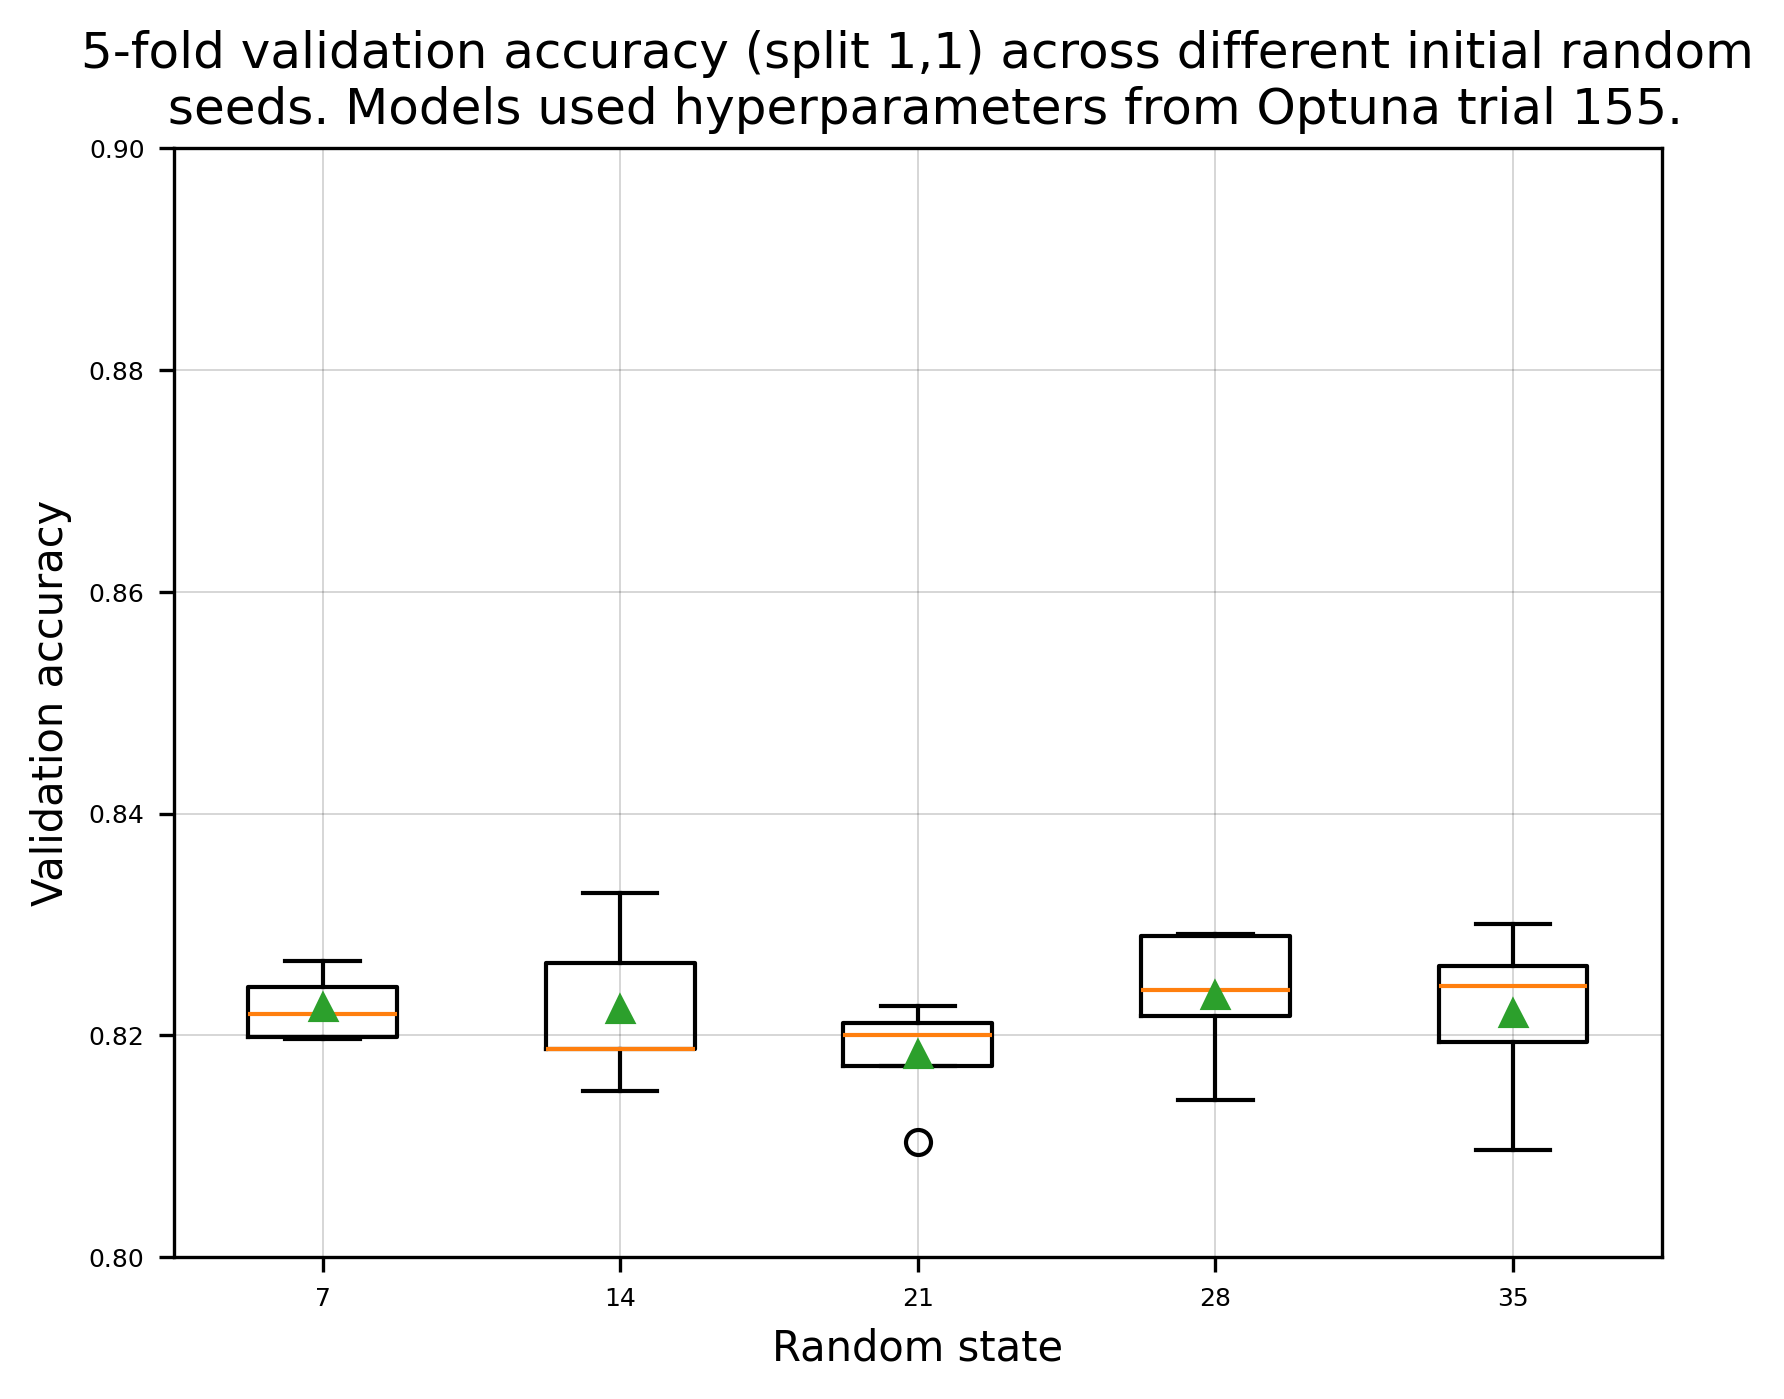

One way ANOVA:  F_onewayResult(statistic=0.5599860837443111, pvalue=0.694300583900376)
     chance      t155
0  0.500172  0.821948
1  0.505893  0.824351
2  0.504863  0.819888
3  0.505550  0.826754
4  0.494793  0.819659


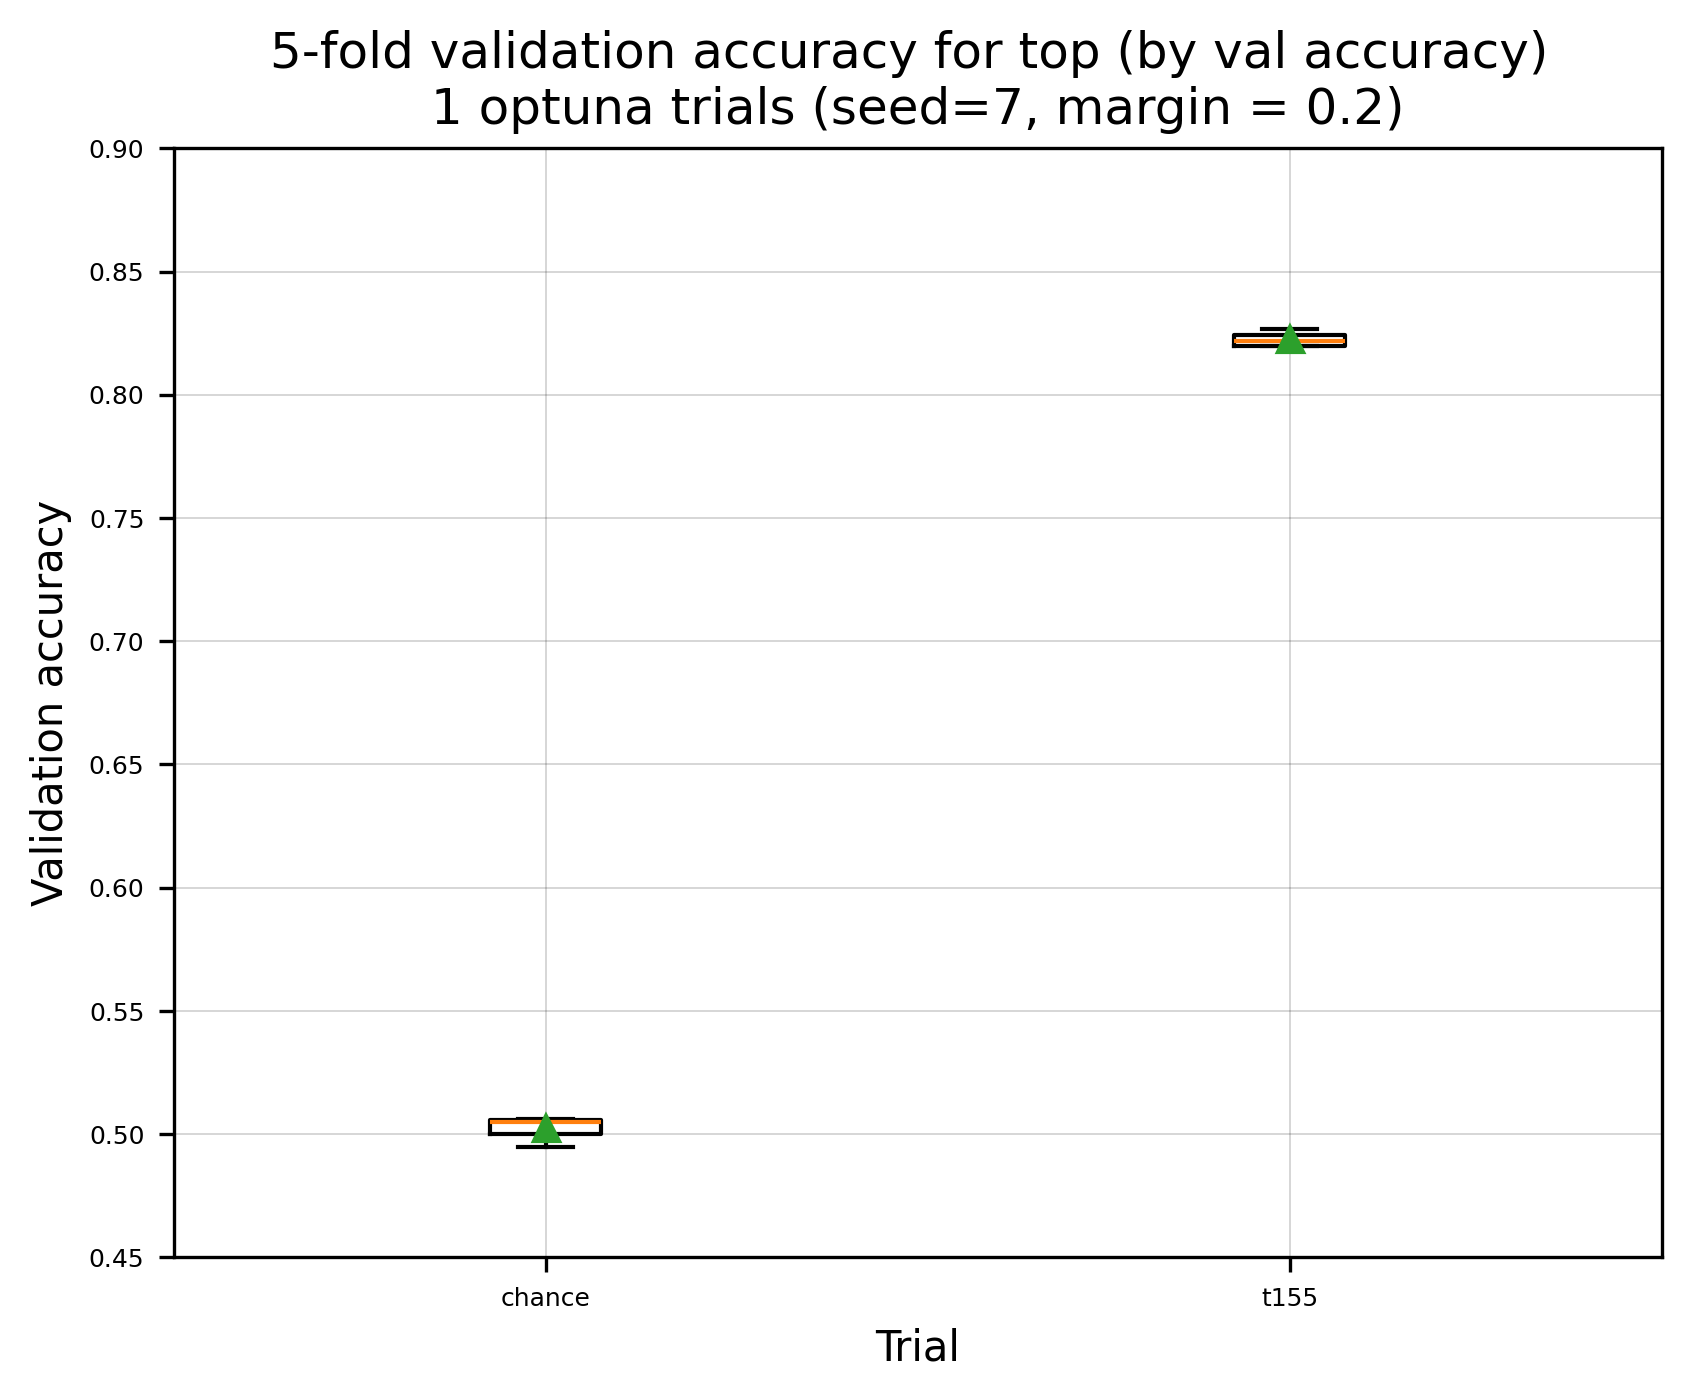

       t155
0  0.821948
1  0.824351
2  0.819888
3  0.826754
4  0.819659
           t155
count  5.000000
mean   0.822520
std    0.003030
min    0.819659
25%    0.819888
50%    0.821948
75%    0.824351
max    0.826754


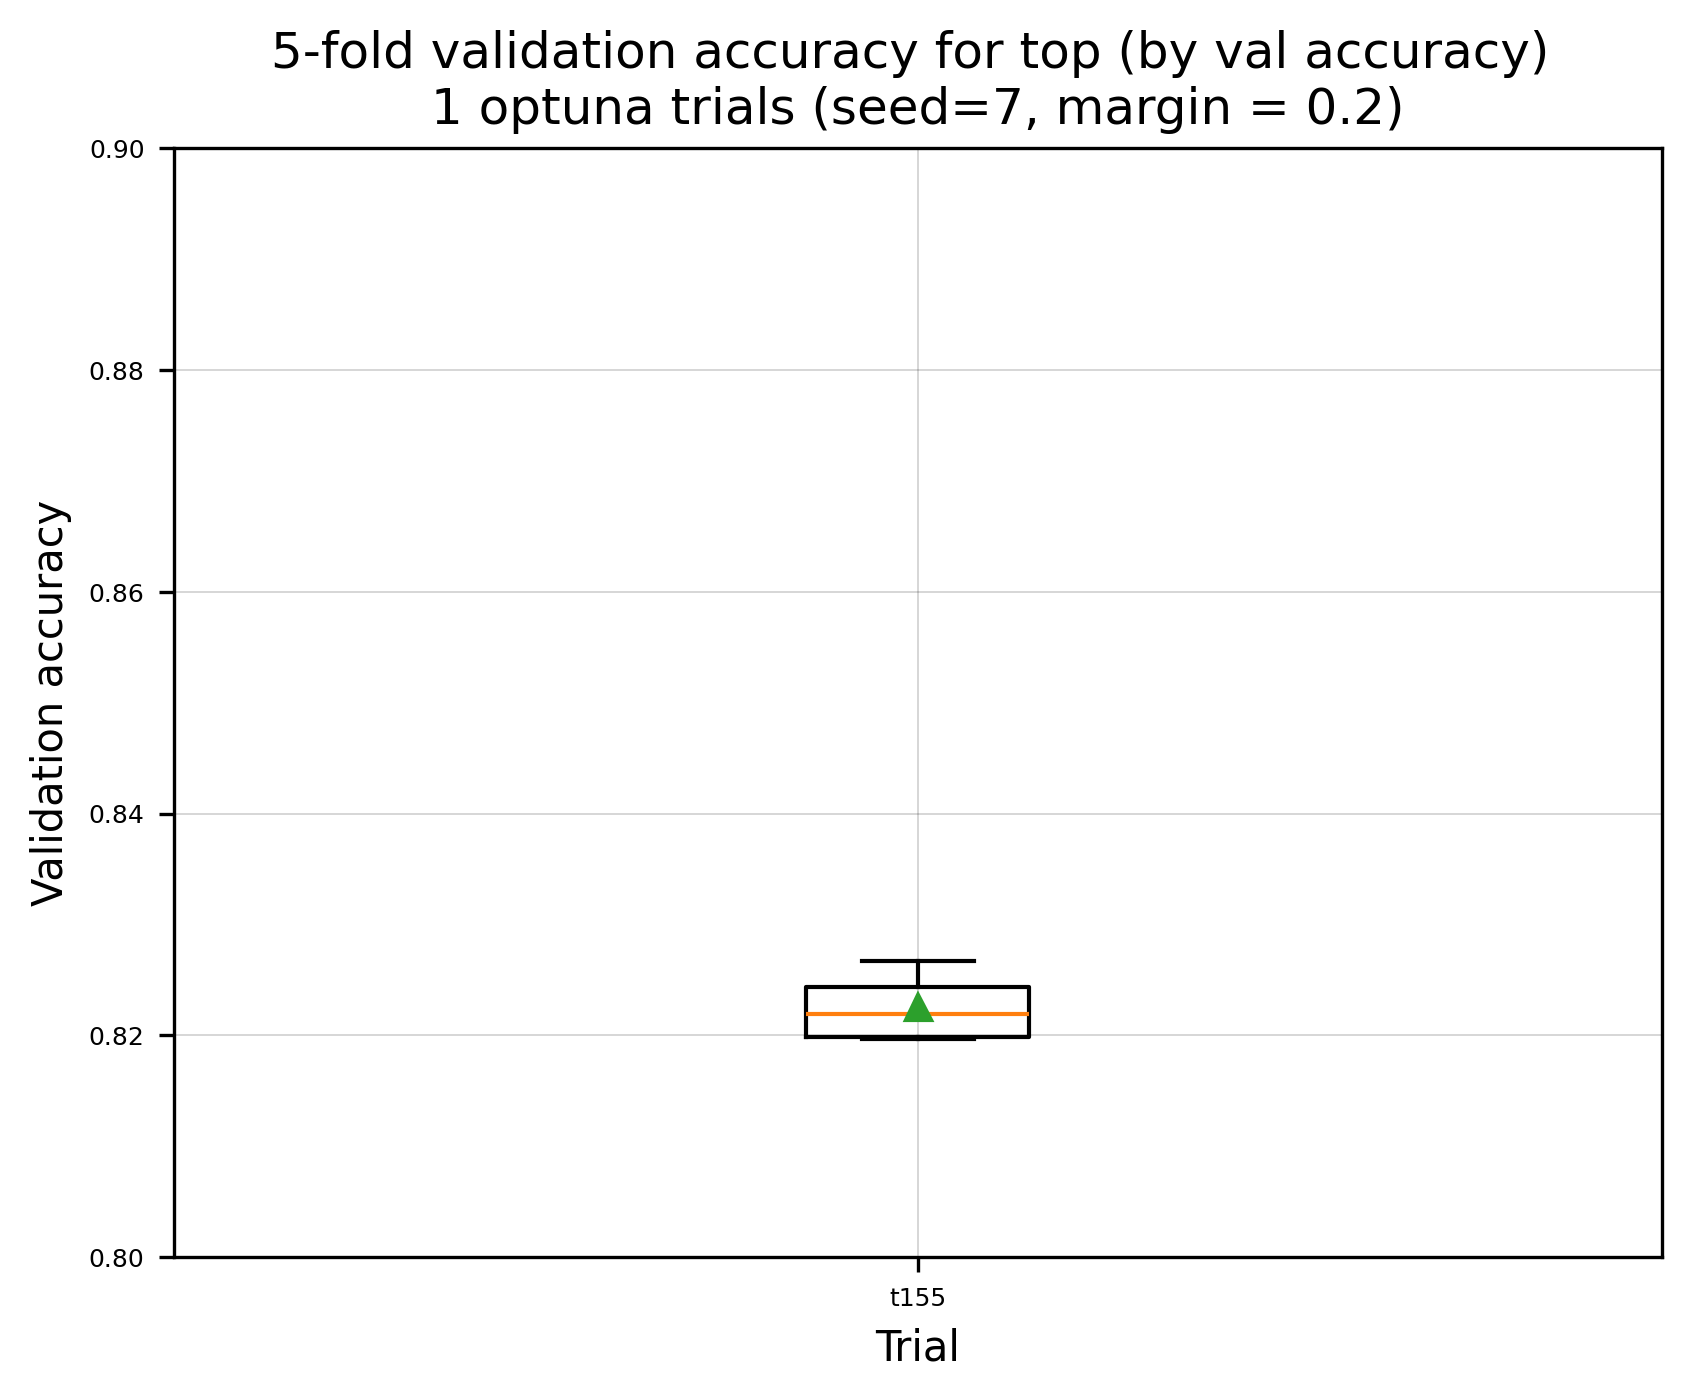

     chance      t155
0  0.497082  0.832818
1  0.501430  0.818744
2  0.493764  0.814967
3  0.501316  0.818744
4  0.494679  0.826525


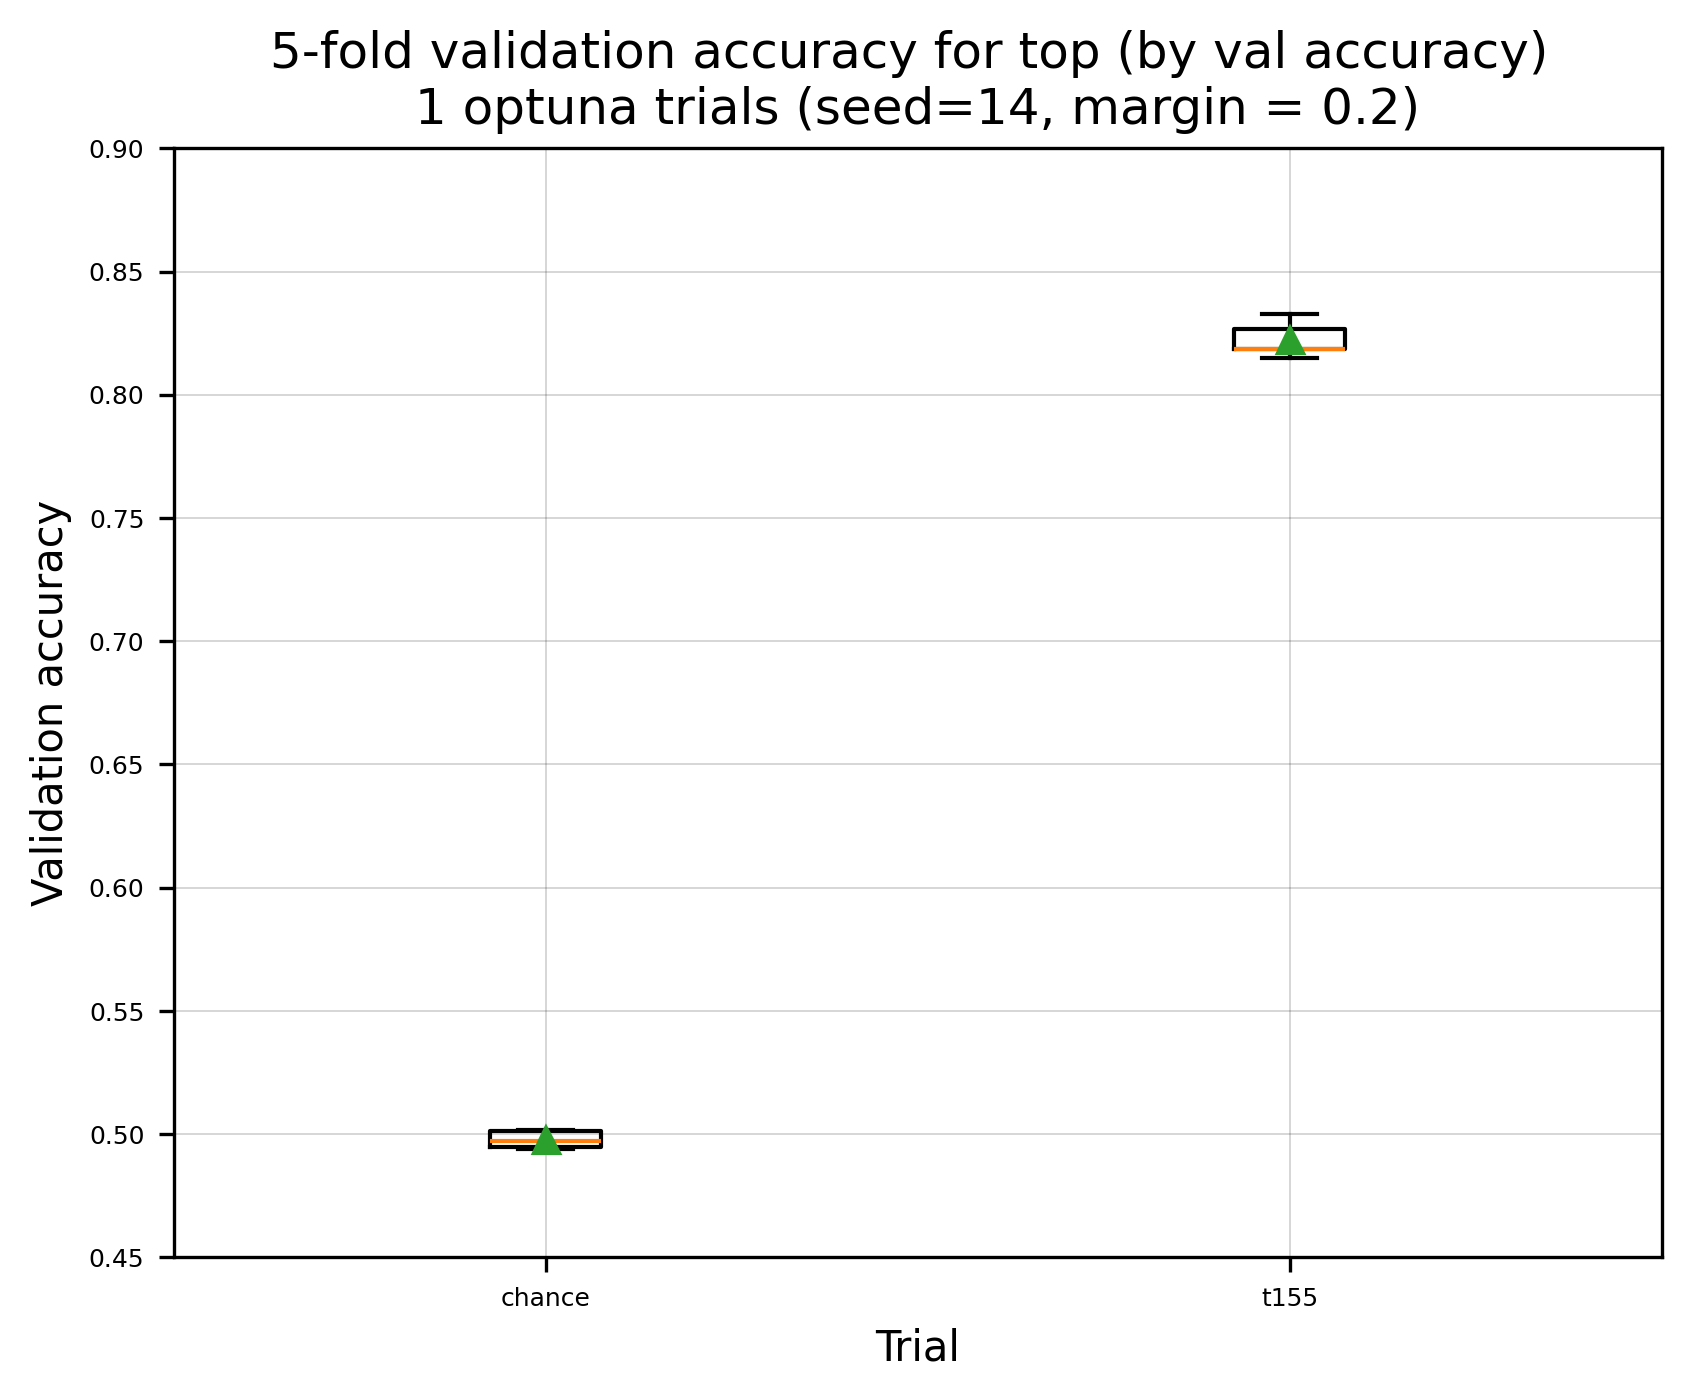

       t155
0  0.832818
1  0.818744
2  0.814967
3  0.818744
4  0.826525
           t155
count  5.000000
mean   0.822360
std    0.007203
min    0.814967
25%    0.818744
50%    0.818744
75%    0.826525
max    0.832818


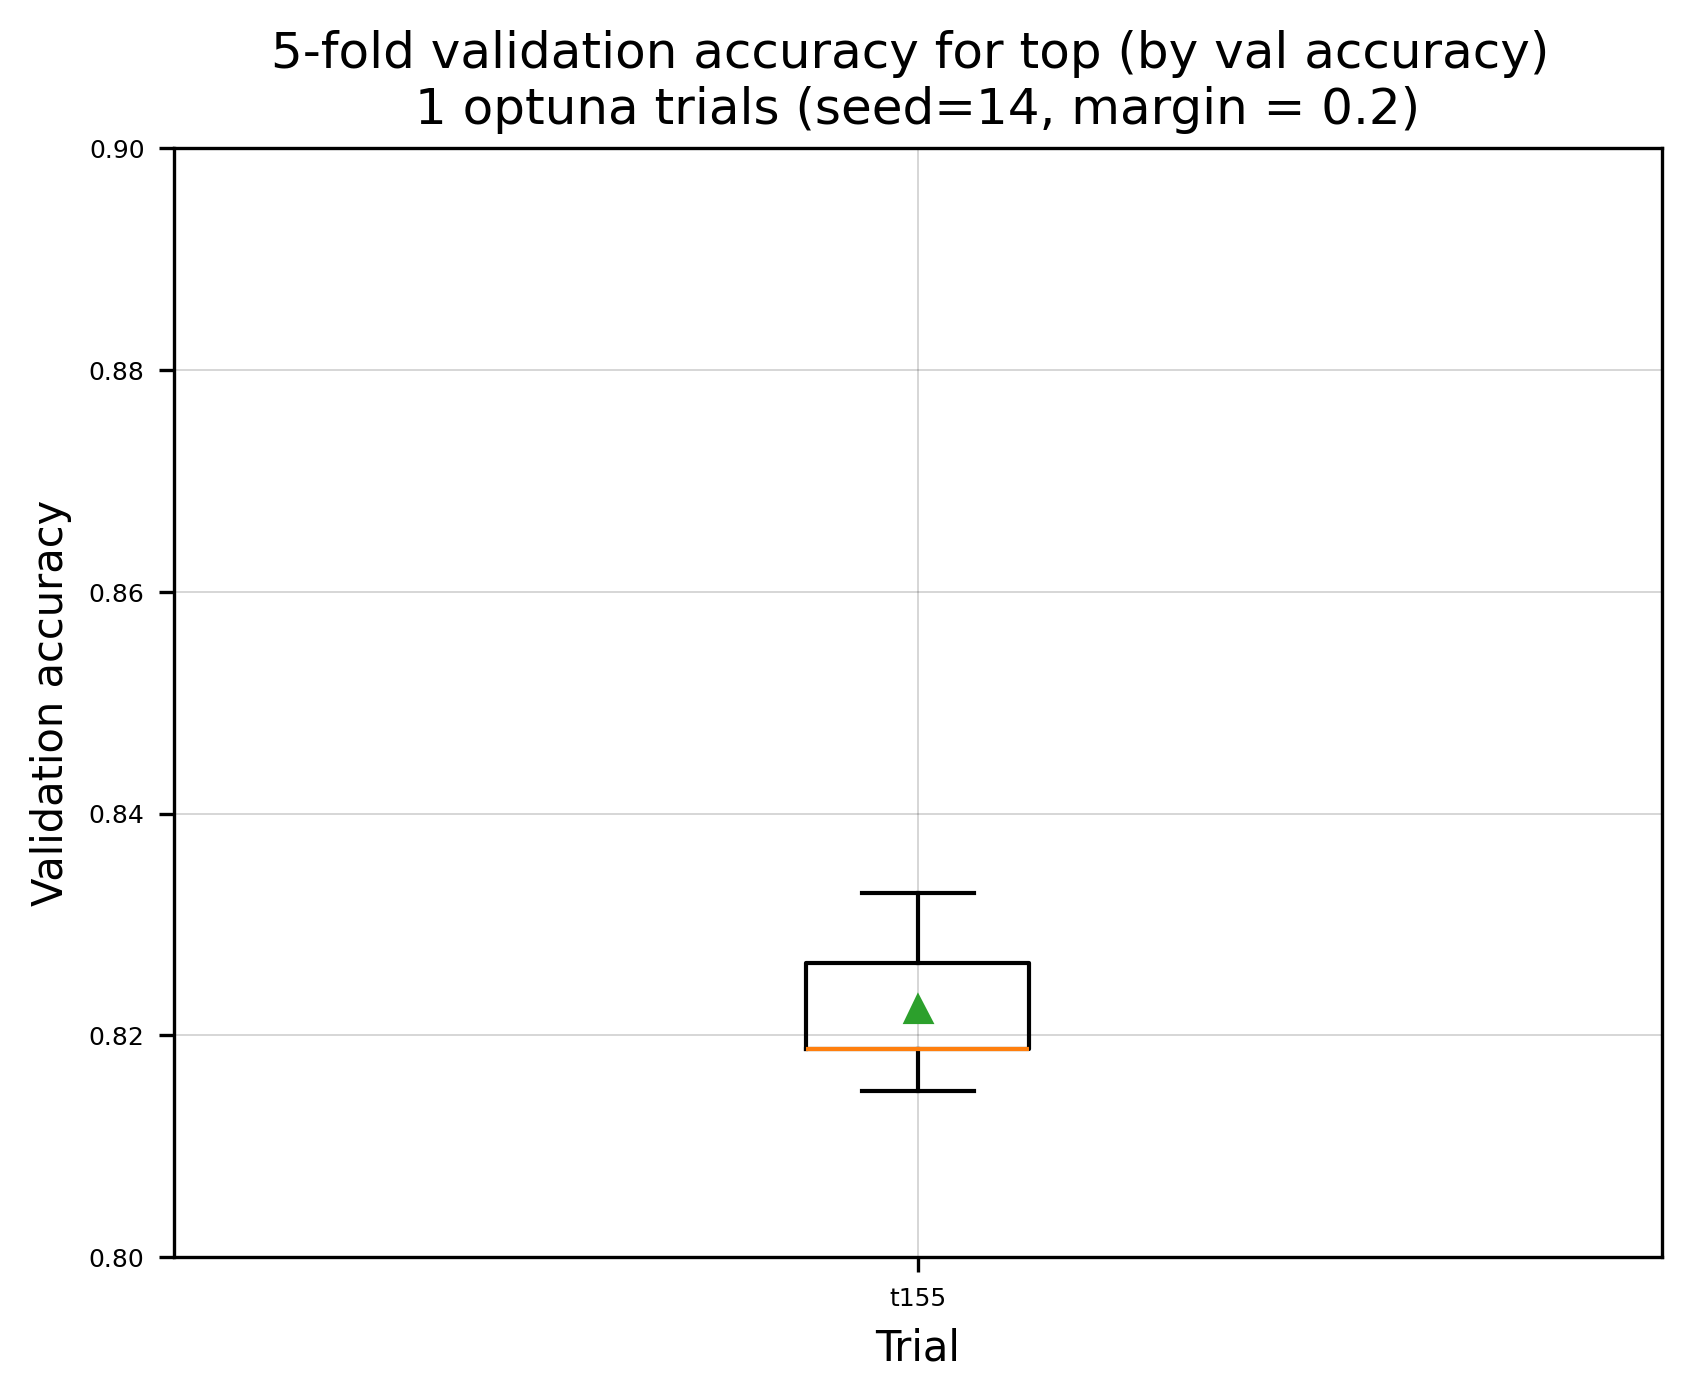

     chance      t155
0  0.504520  0.820002
1  0.507610  0.810390
2  0.503605  0.817256
3  0.510814  0.822634
4  0.495709  0.821147


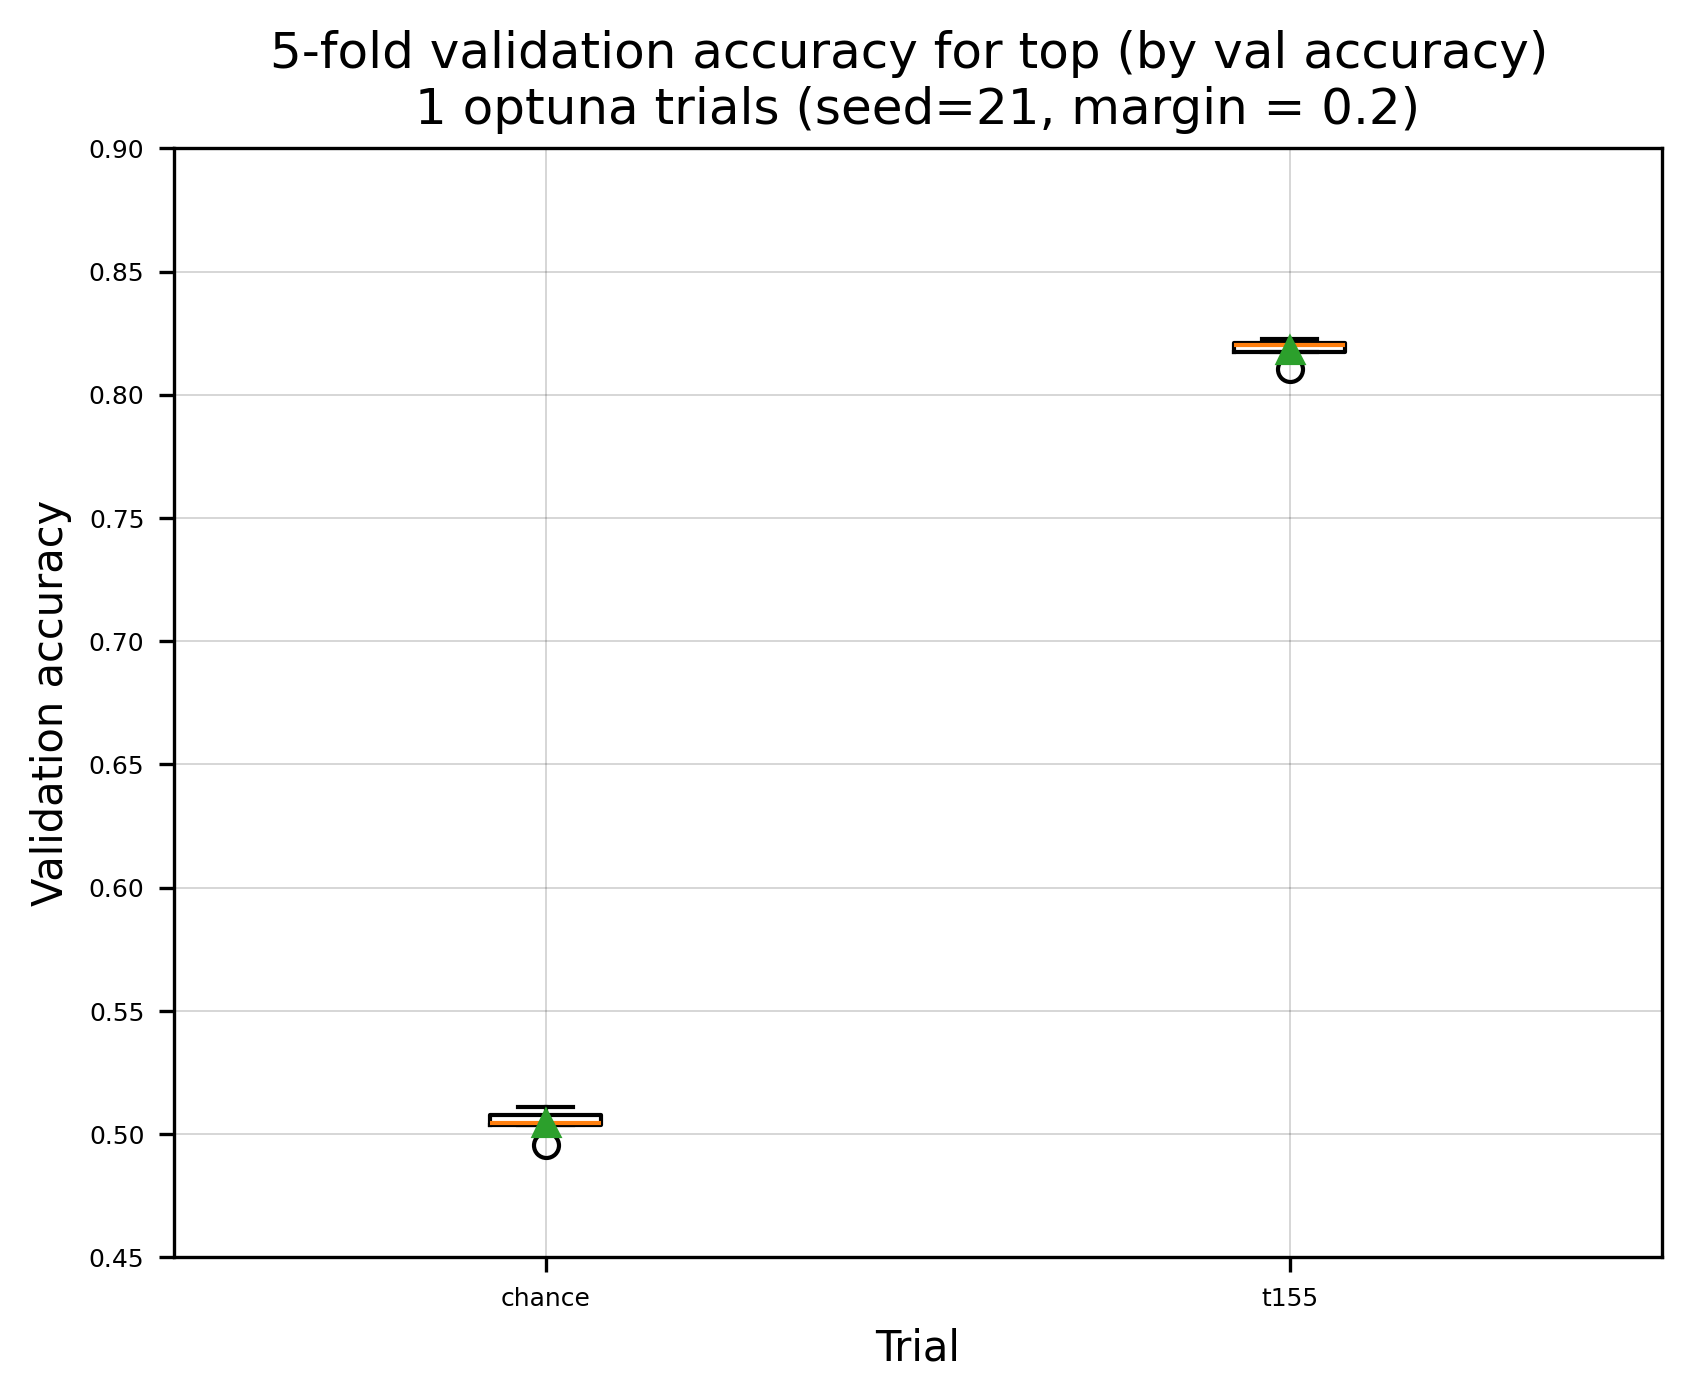

       t155
0  0.820002
1  0.810390
2  0.817256
3  0.822634
4  0.821147
           t155
count  5.000000
mean   0.818286
std    0.004833
min    0.810390
25%    0.817256
50%    0.820002
75%    0.821147
max    0.822634


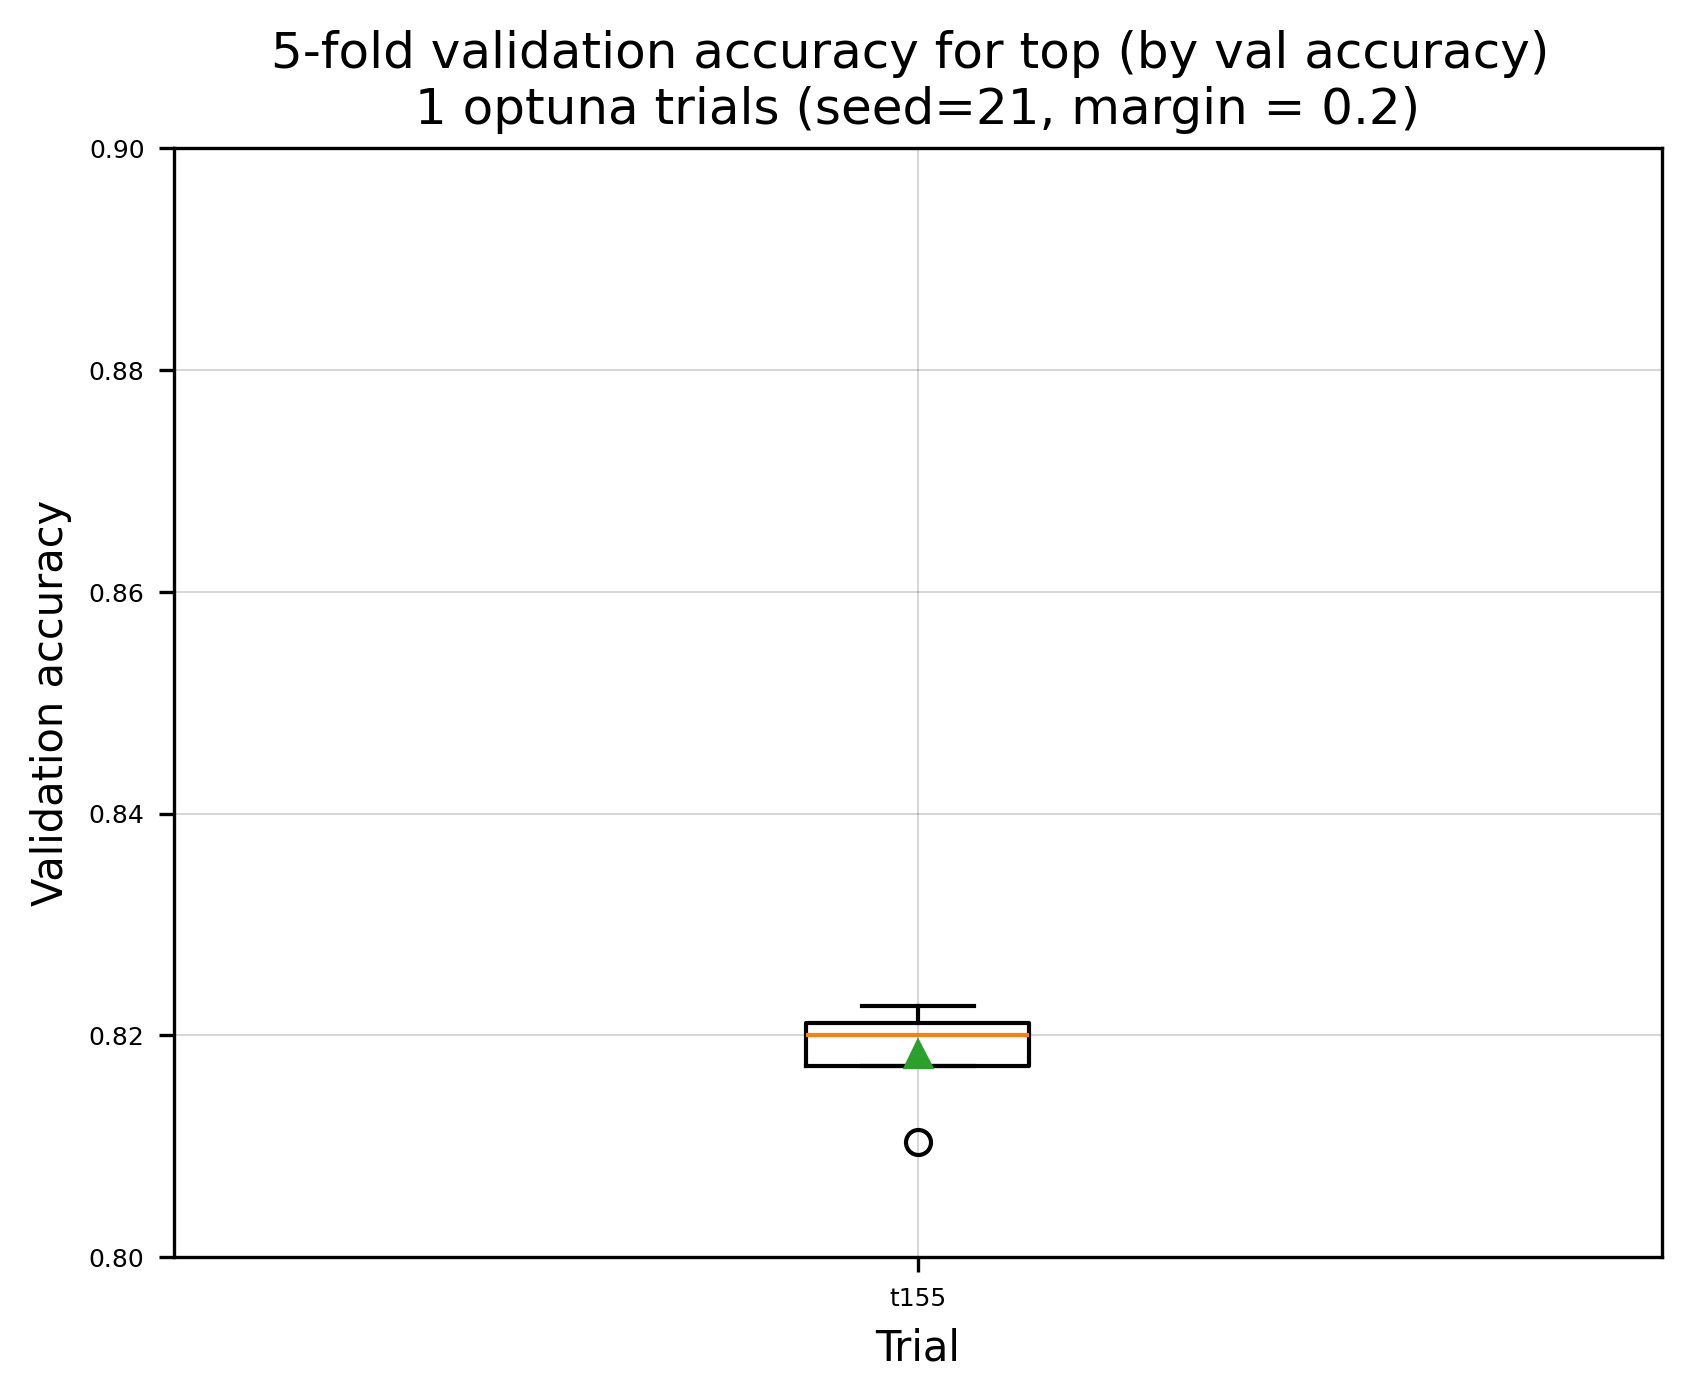

     chance      t155
0  0.497997  0.828928
1  0.499142  0.814166
2  0.503605  0.824122
3  0.497769  0.829157
4  0.495251  0.821719


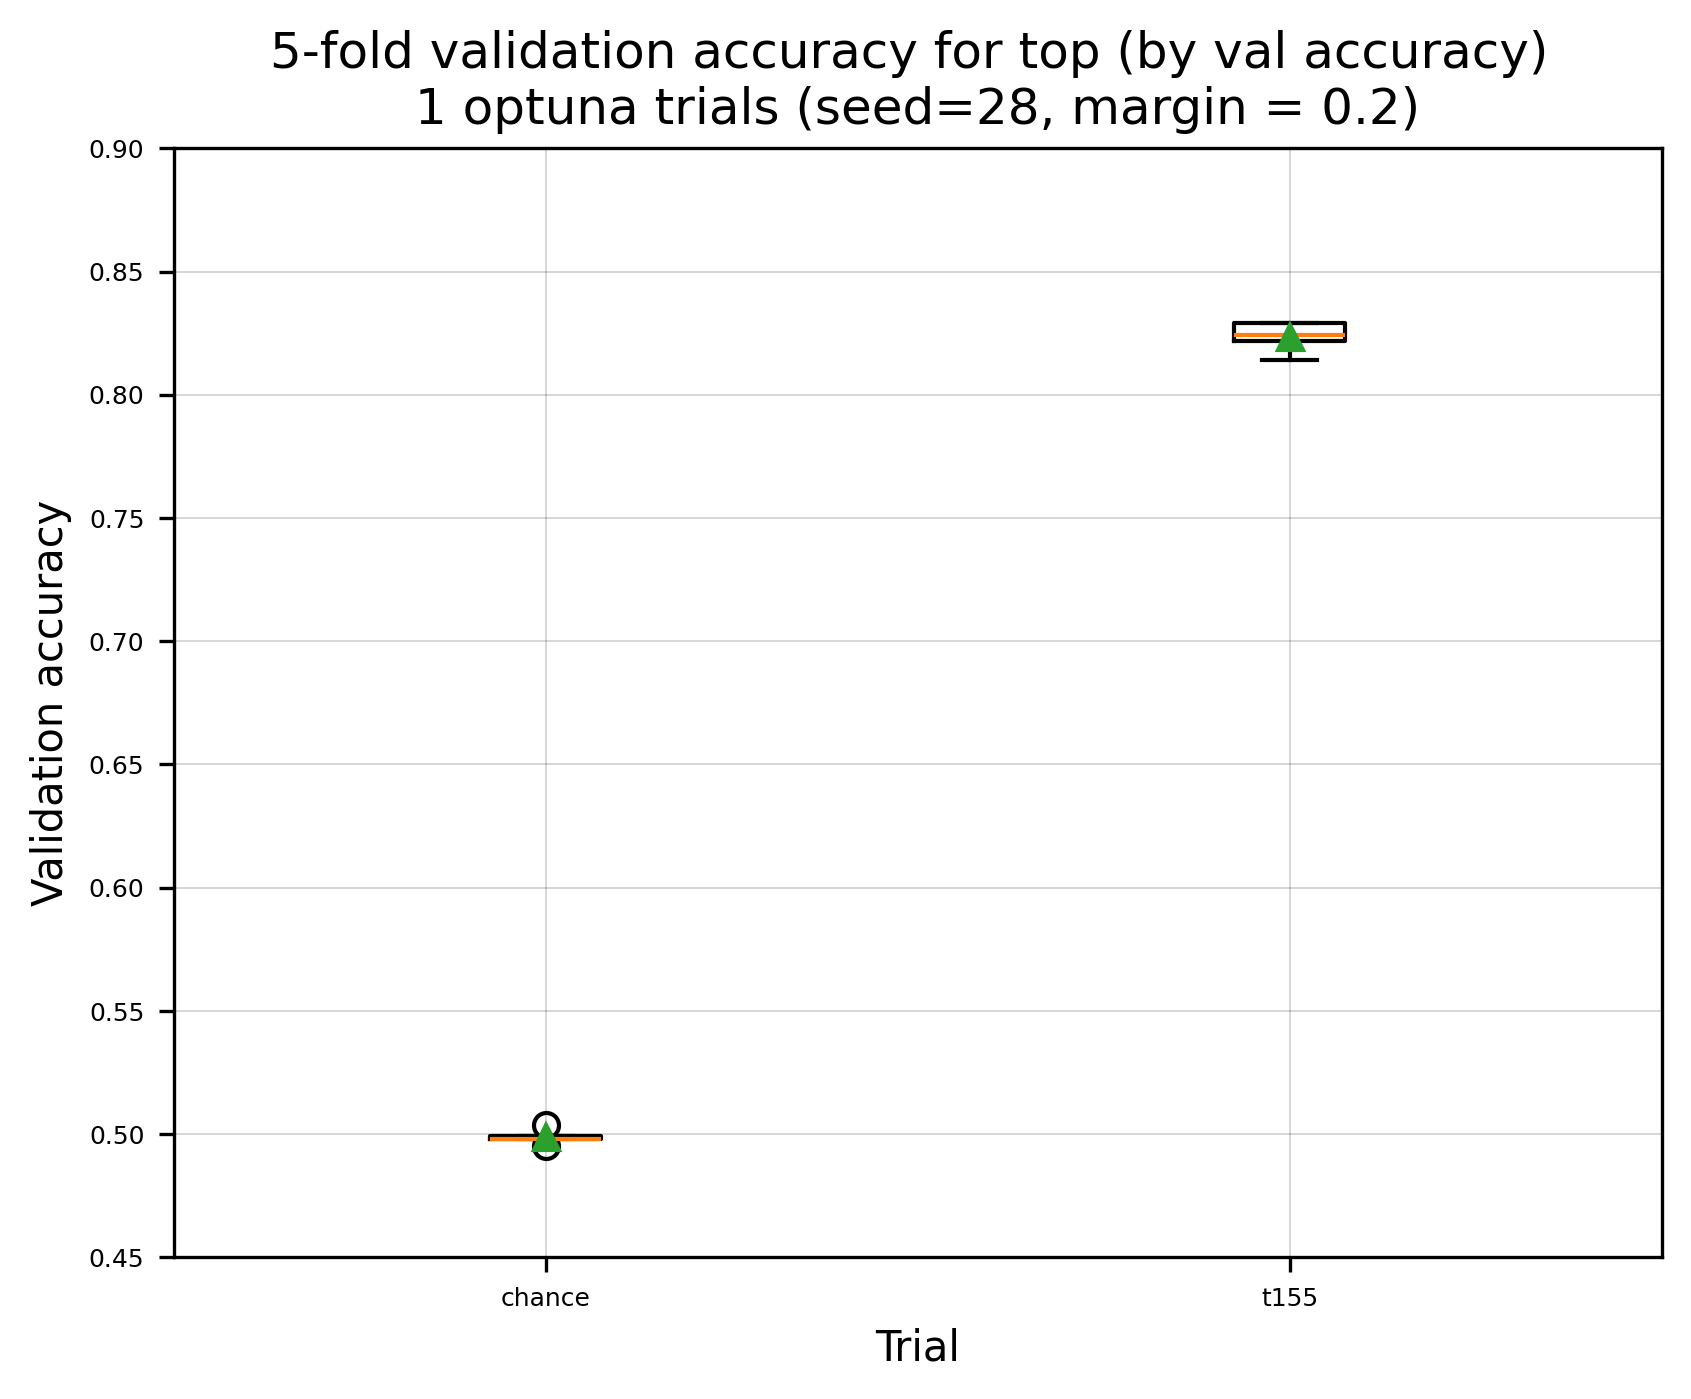

       t155
0  0.828928
1  0.814166
2  0.824122
3  0.829157
4  0.821719
           t155
count  5.000000
mean   0.823618
std    0.006166
min    0.814166
25%    0.821719
50%    0.824122
75%    0.828928
max    0.829157


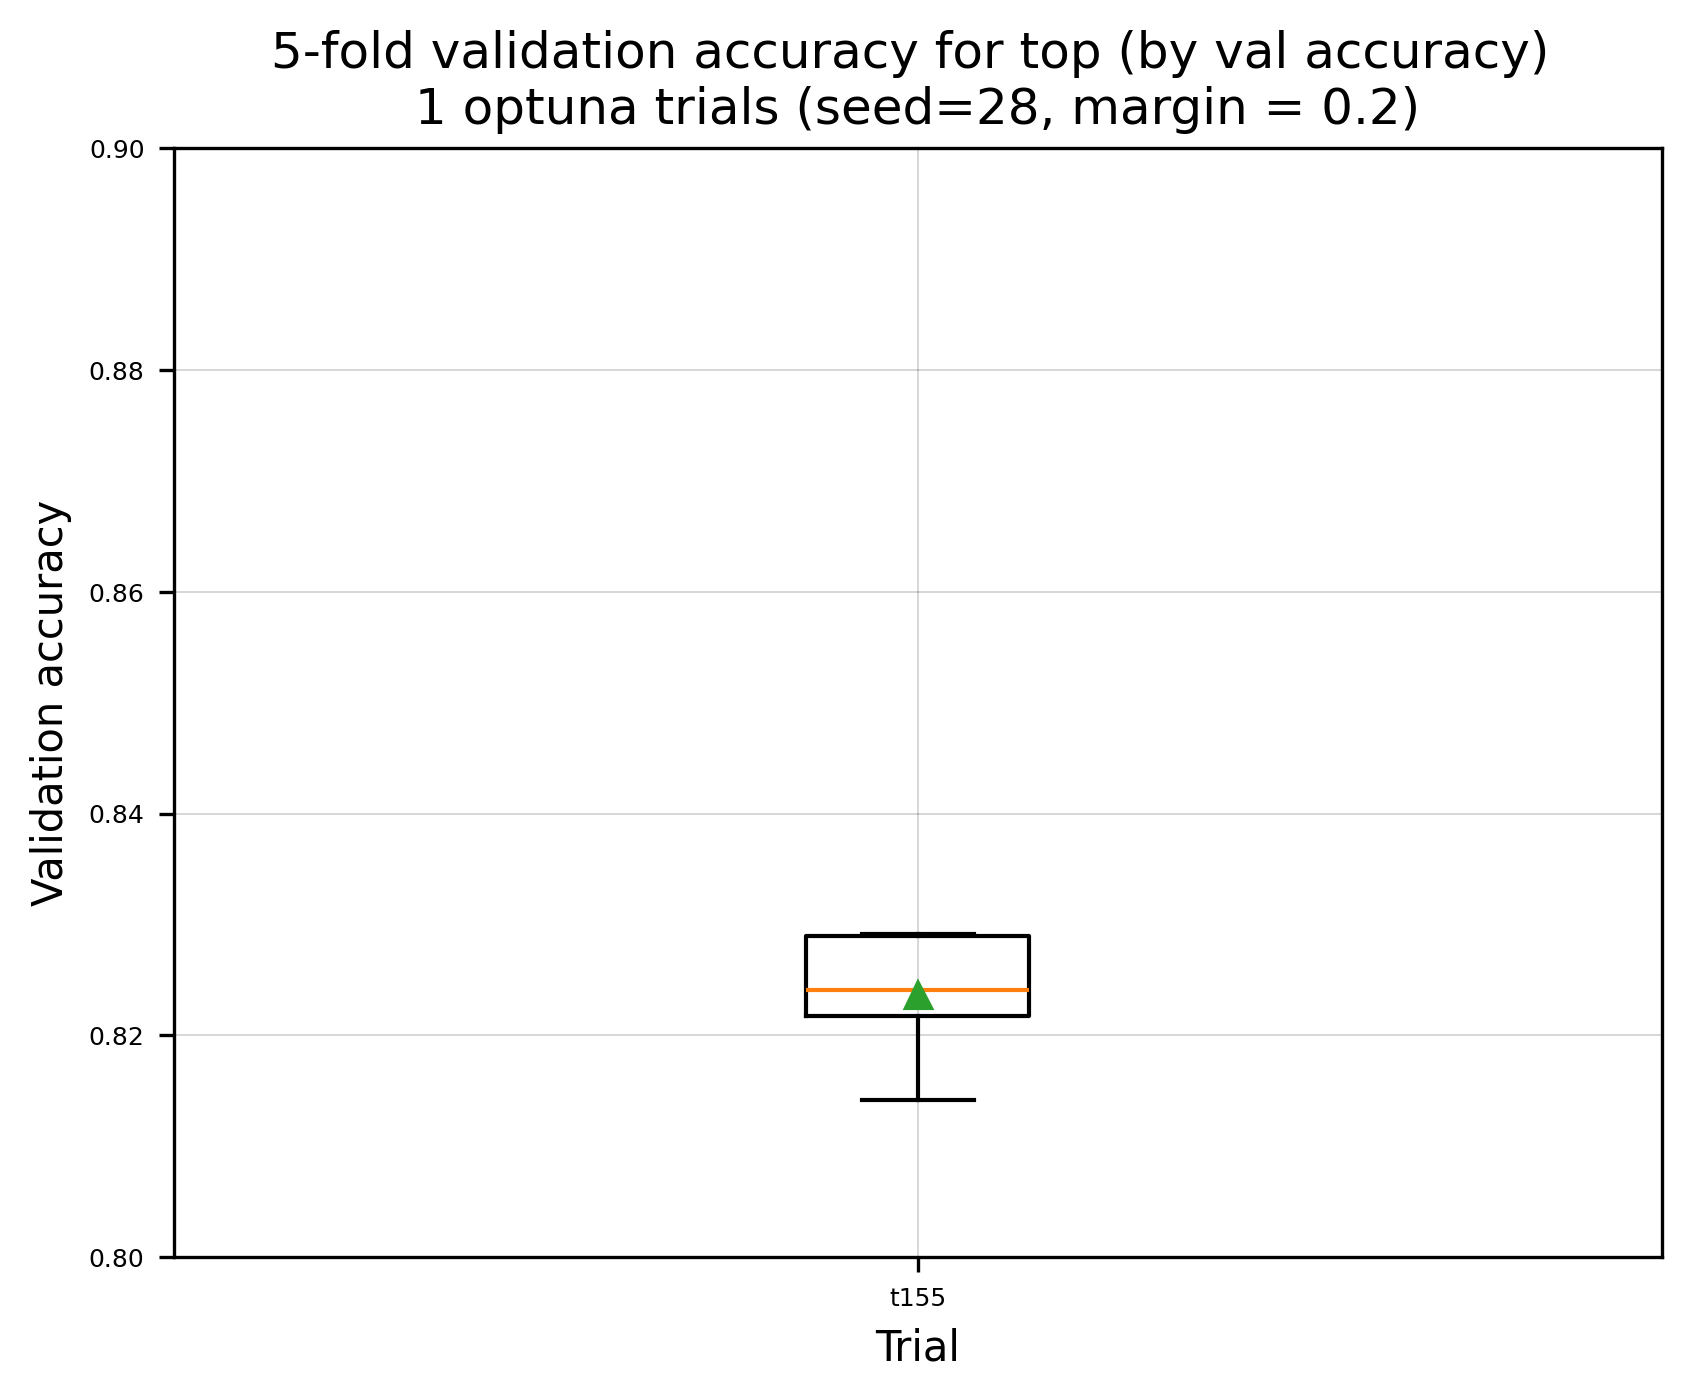

     chance      t155
0  0.492047  0.809704
1  0.501888  0.824465
2  0.508983  0.826296
3  0.495709  0.819430
4  0.496510  0.830072


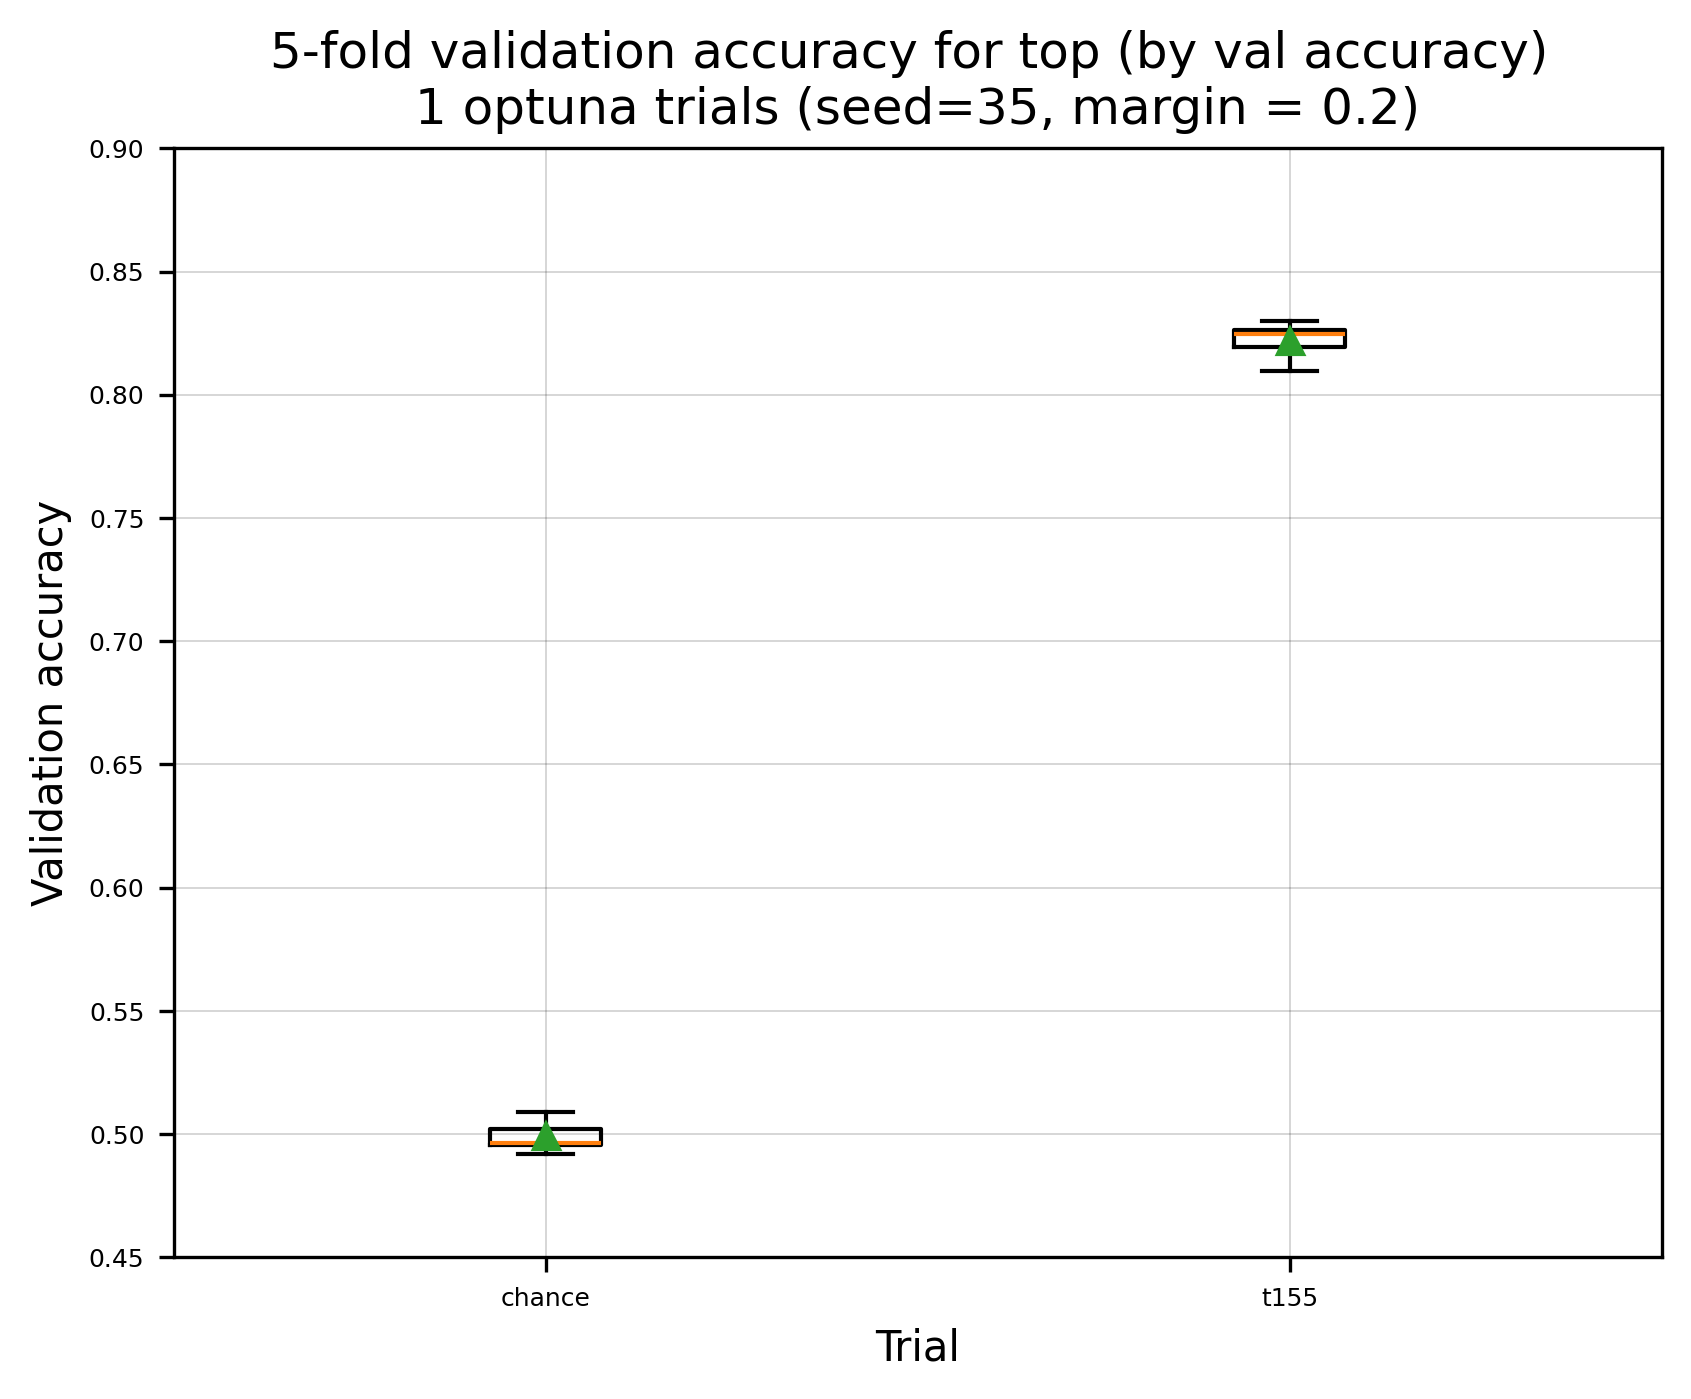

       t155
0  0.809704
1  0.824465
2  0.826296
3  0.819430
4  0.830072
           t155
count  5.000000
mean   0.821993
std    0.007866
min    0.809704
25%    0.819430
50%    0.824465
75%    0.826296
max    0.830072


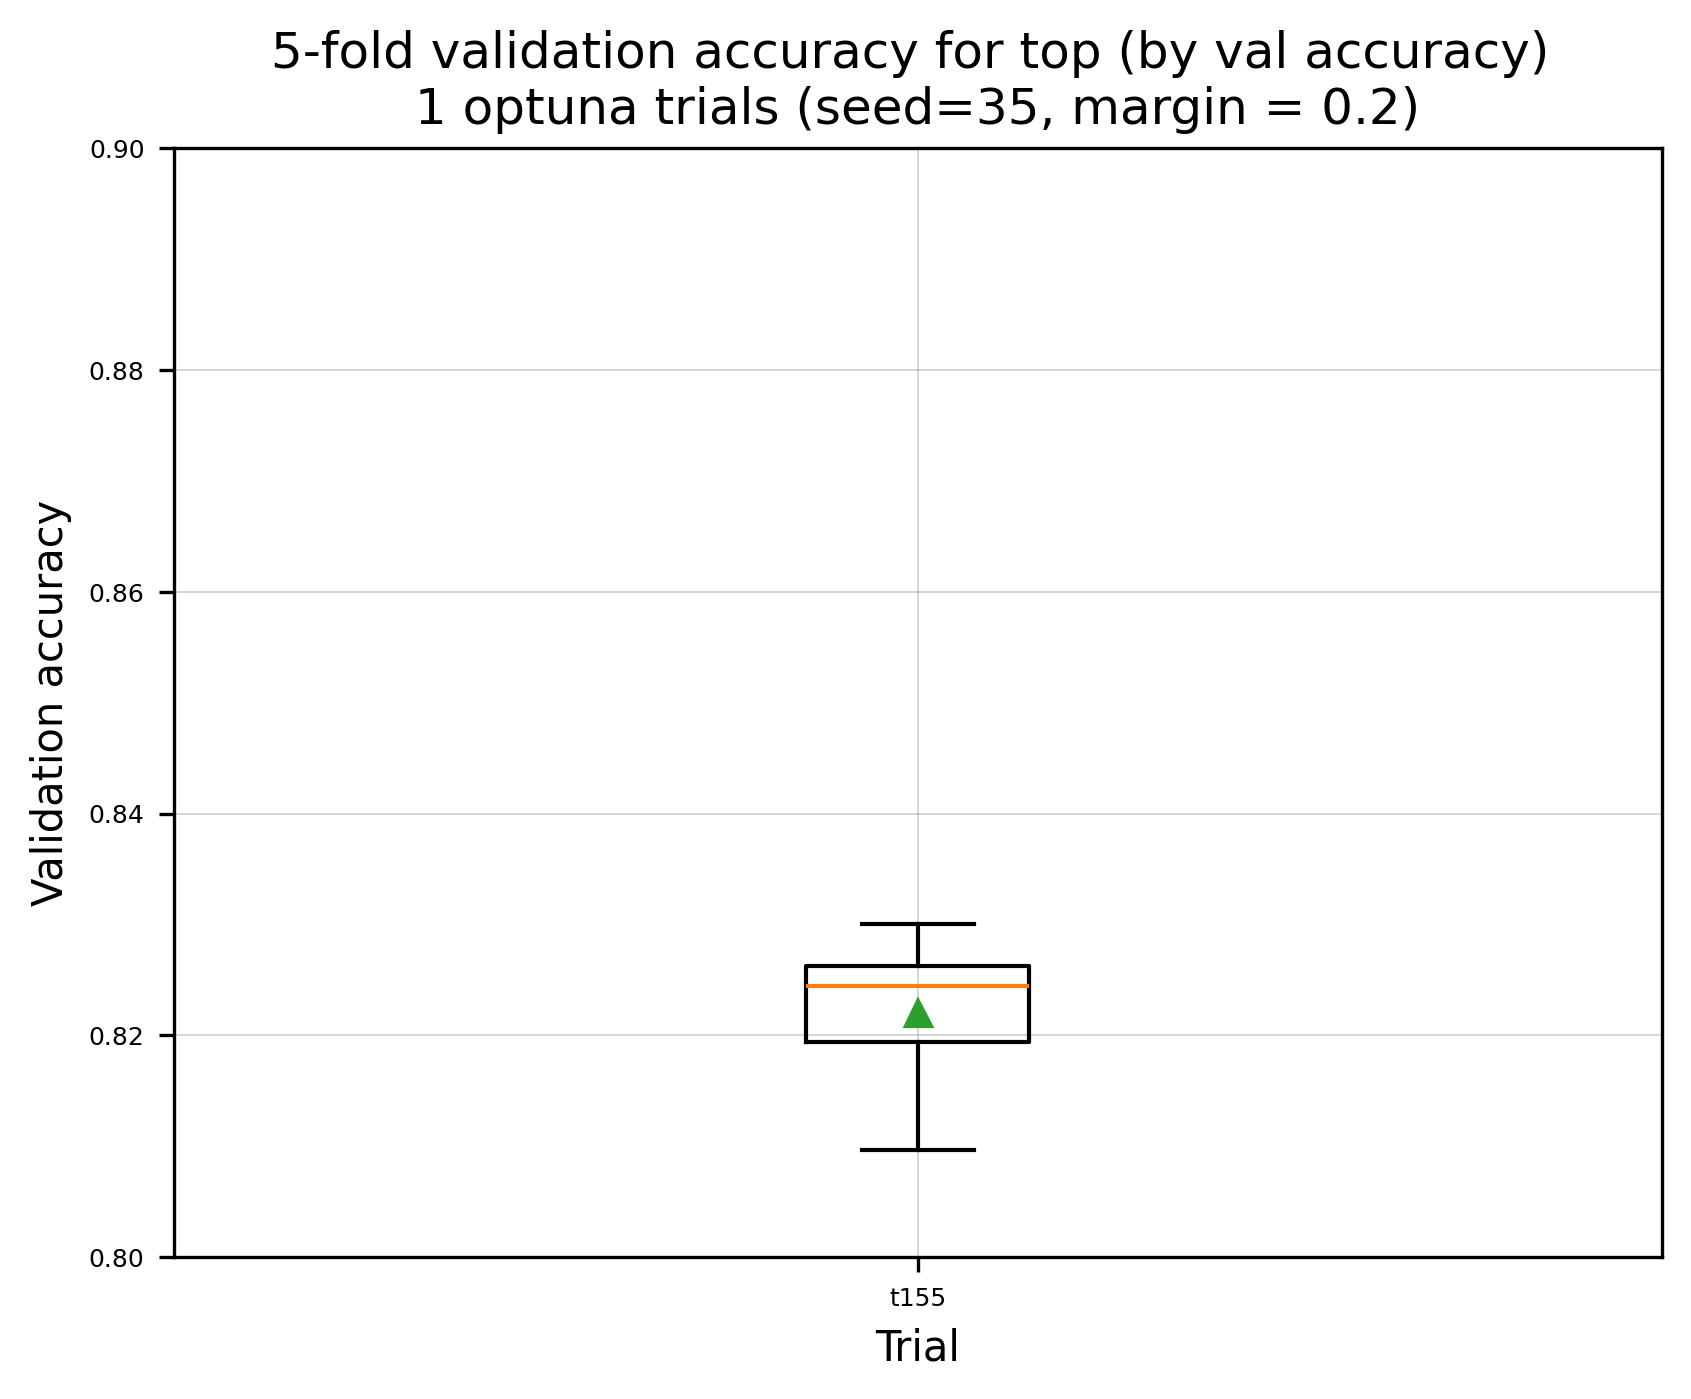

In [6]:
# Top models

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
xval_plot_data_dir=working_dir/Path("plot_data")/Path("TripletLoss")/Path("xfold")
xval_plot_data_dir.mkdir(exist_ok=True, parents=True)


model_trial_number=155
working_dir=Path("working_dir")
xval_plot_data_dir=working_dir/Path("plot_data")/Path("TripletLoss")/Path("xfold")
xval_plot_data_dir.mkdir(exist_ok=True, parents=True)
xval_summary_df=pd.DataFrame()
xval_dir_name="optuna_scan_2aee8fcda8_1node_HPC1_noprunekey_user_attrs_val_accuracy_repeat1_seed"
# Plot with chance included and excluded:
for seed in [7,14,21,28,35]:
    xval_file=Path(working_dir)/Path(f"TripletLoss/xval/optuna_scan_2aee8fcda8_1node_HPC1_noprunekey_user_attrs_val_accuracy_repeat1_seed{seed}/xval_scores_t{model_trial_number}.csv")
    xval_summary_df=pd.concat([xval_summary_df, pd.DataFrame.from_dict({seed:pd.read_csv(xval_file, index_col=[1])['val_accuracy'].values})],axis=1,ignore_index=False)
    xval_summary_df.index.name="Trial"

display(xval_summary_df)
display(xval_summary_df.describe())

fig, ax=plt.subplots(dpi=300)
#xval_df=xval_df.reindex(xval_df.mean().sort_values().index, axis=1)
ax.boxplot(xval_summary_df, showmeans=True, labels=xval_summary_df.columns)
ax.set_xlabel("Random state")
ax.set_ylabel("Validation accuracy")
xval_summary_df.to_csv(xval_plot_data_dir/f"xval_scores_t{model_trial_number}.csv")
ax.grid(which='major', color='black', linewidth=0.075)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set(title=f'5-fold validation accuracy (split 1,1) across different initial random\n seeds. Models used hyperparameters from Optuna trial 155.')
ax.set_ylim((0.8, 0.9))
_, xlabels = plt.xticks()
fig.savefig(xval_plot_data_dir/f"optuna_scan_2aee8fcda8_1node_HPC1_noprunekey_user_attrs_val_accuracy_repeat1_merged_seeds.svg")
fig.savefig(xval_plot_data_dir/f"optuna_scan_2aee8fcda8_1node_HPC1_noprunekey_user_attrs_val_accuracy_repeat1_merged_seeds.png", dpi=300)
plt.show()
from scipy.stats import f_oneway
print("One way ANOVA: ", f_oneway(xval_summary_df[7], xval_summary_df[14], xval_summary_df[21], xval_summary_df[28], xval_summary_df[35],))

for seed in [7,14,21,28,35]:
    xval_dir=Path(working_dir)/f"TripletLoss/xval/optuna_scan_2aee8fcda8_1node_HPC1_noprunekey_user_attrs_val_accuracy_repeat1_seed{seed}"
    sorted_by="val accuracy"
    xval_files=xval_dir.glob("xval_scores_*.csv")
    fig, ax=plt.subplots(dpi=300)
    xval_df=pd.DataFrame.from_dict({str(f.name).split("_")[-1].split(".")[0]:pd.read_csv(f, index_col=[0])['val_accuracy'].values for f in xval_files})
    #xval_df=xval_df.reindex(xval_df.mean().sort_values().index, axis=1)
    xval_df=xval_df.reindex(sorted(xval_df.columns), axis=1)
    print(xval_df)
    ax.boxplot(xval_df, showmeans=True, labels=xval_df.columns)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Validation accuracy")
    xval_df.to_csv(xval_plot_data_dir/f"summary_xval_with_chance_baseline_optuna_scan_2aee8fcda8_1node_HPC1_seed{seed}.csv")
    ax.grid(which='major', color='black', linewidth=0.075)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set(title=f'5-fold validation accuracy for top (by {sorted_by}) \n{xval_df.shape[1]-1} optuna trials (seed={seed}, margin = 0.2)')
    _, xlabels = plt.xticks()
    ax.set_ylim((0.45, 0.9))
    fig.savefig(xval_plot_data_dir/f"summary_xval_with_chance_baseline_optuna_scan_2aee8fcda8_1node_HPC1_seed{seed}.svg")
    fig.savefig(xval_plot_data_dir/f"summary_xval_with_chance_baseline_optuna_scan_2aee8fcda8_1node_HPC1_seed{seed}.png", dpi=300)
    plt.show()

    xval_dir=Path(working_dir)/f"TripletLoss/xval/optuna_scan_2aee8fcda8_1node_HPC1_noprunekey_user_attrs_val_accuracy_repeat1_seed{seed}"
    sorted_by="val accuracy"
    xval_files=xval_dir.glob("xval_scores_t*.csv")
    fig, ax=plt.subplots(dpi=300)
    xval_df=pd.DataFrame.from_dict({str(f.name).split("_")[-1].split(".")[0]:pd.read_csv(f, index_col=[0])['val_accuracy'].values for f in xval_files})
    #xval_df=xval_df.reindex(xval_df.mean().sort_values().index, axis=1)
    xval_df=xval_df.reindex(sorted(xval_df.columns), axis=1)
    print(xval_df)
    print(xval_df.describe())
    ax.boxplot(xval_df, showmeans=True, labels=xval_df.columns)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Validation accuracy")
    xval_df.to_csv(xval_plot_data_dir/f"summary_xval_optuna_scan_2aee8fcda8_1node_HPC1_seed{seed}.csv")
    ax.grid(which='major', color='black', linewidth=0.075)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set(title=f'5-fold validation accuracy for top (by {sorted_by}) \n{xval_df.shape[1]} optuna trials (seed={seed}, margin = 0.2)')
    _, xlabels = plt.xticks()
    ax.set_ylim((0.8, 0.9))

    fig.savefig(xval_plot_data_dir/f"optuna_scan_2aee8fcda8_1node_HPC1_seed{seed}.svg")
    fig.savefig(xval_plot_data_dir/f"optuna_scan_2aee8fcda8_1node_HPC1_seed{seed}.png", dpi=300)
    plt.show()





### Visualize best model test split performance across seeds


[PosixPath('working_dir/plot_data/TripletLoss/155/test_accuracies/summary_test_accuracies.png'), PosixPath('working_dir/plot_data/TripletLoss/155/test_accuracies/test_accuracy_cls_5_moas_5_seed_21.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/test_accuracies/test_accuracy_cls_3_moas_4_seed_14.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/test_accuracies/test_accuracy_cls_1_moas_5_seed_35.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/test_accuracies/test_accuracy_cls_5_moas_5_seed_28.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/test_accuracies/test_accuracy_cls_2_moas_2_seed_35.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/test_accuracies/test_accuracy_cls_3_moas_4_seed_28.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/test_accuracies/test_accuracy_cls_3_moas_2_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/test_accuracies/test_accuracy_cls_4_moas_3_seed_35.csv'), PosixPath('working_dir/plot_data/TripletLoss/155

,cell line split,MOA split,seed,test accuracy
0,5,5,21,0.836262
0,3,4,14,0.816716
0,1,5,35,0.834705
0,5,5,28,0.847716
0,2,2,35,0.862124
...,...,...,...,...
0,2,1,7,0.850635
0,5,3,35,0.812099
0,3,3,7,0.820181
0,1,3,21,0.843457


cell line split           MOA split           test accuracy          
                mean       std      mean       std          mean       std
seed                                                                      
7                3.0  1.443376       3.0  1.443376      0.831200  0.018138
14               3.0  1.443376       3.0  1.443376      0.829037  0.024112
21               3.0  1.443376       3.0  1.443376      0.825384  0.034007
28               3.0  1.443376       3.0  1.443376      0.832708  0.017276
35               3.0  1.443376       3.0  1.443376      0.826892  0.027180

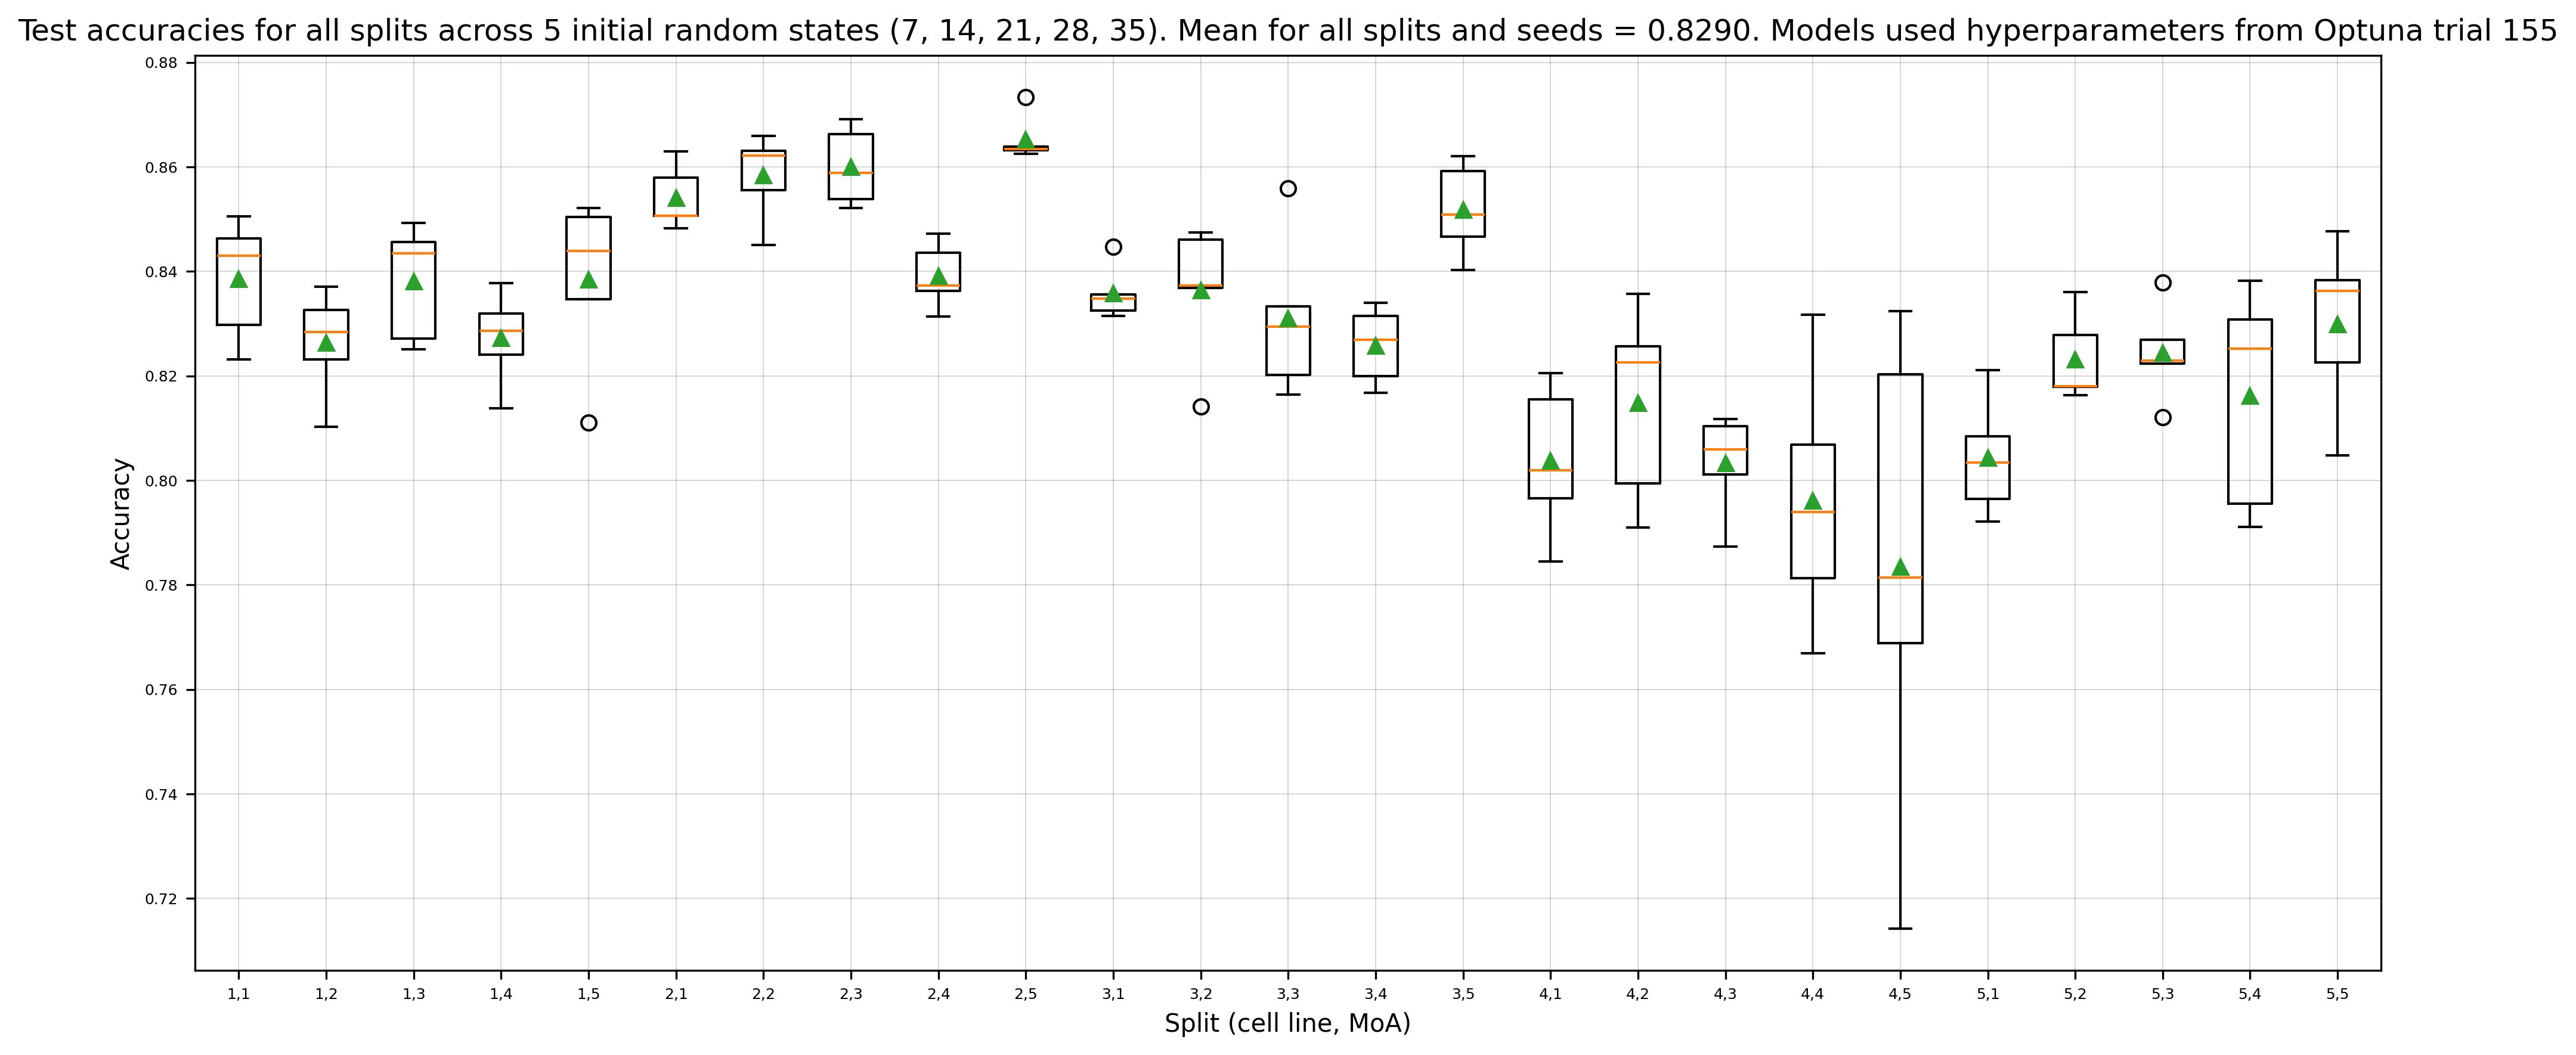

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
working_dir=Path("working_dir")
DB_FILE="optuna_scan_margin_0.2.db"
TRIAL_NUMBER=681
accuracies_dir=working_dir/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("test_accuracies")
print(list(accuracies_dir.glob("*")))
seeds_list=[7,14,21,28,35]
accuracies_files=[]
    
test_accuracy_df=pd.concat([pd.read_csv(f, index_col=[0]) for f in accuracies_dir.glob("test_accuracy_*.csv")])
test_accuracy_df.to_csv(working_dir/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("test_accuracies")/"summary_test_accuracies.csv")
display(test_accuracy_df)
display(test_accuracy_df.groupby("seed").agg(["mean", "std"]))
fig, ax=plt.subplots(1, dpi=300, figsize=(13,6))
ax.boxplot(
    [test_accuracy_df.query(f"`cell line split`=={cls} and `MOA split`=={moas}")['test accuracy'] for cls in range(1,5+1) for moas in range(1,5+1)]
    , showmeans=True, labels=[f"{cls},{moas}" for cls in range(1,5+1) for moas in range(1,5+1)])
ax.set_xlabel("Split (cell line, MoA)")
ax.set_ylabel("Accuracy")
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_title(f"Test accuracies for all splits across 5 initial random states (7, 14, 21, 28, 35). Mean for all splits and seeds = {test_accuracy_df['test accuracy'].mean():.4f}. Models used hyperparameters from Optuna trial 155")
ax.grid(which='major', color='black', linewidth=0.075)
plt.tight_layout()
fig.savefig(working_dir/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("test_accuracies")/"summary_test_accuracies.svg")
fig.savefig(working_dir/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("test_accuracies")/"summary_test_accuracies.png", dpi=300)

